In [20]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

from util import *
from model.pinn import PINNs
from model.pinnsformer_act import PINNsformer

In [21]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [35]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [34]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res

array([[0.        , 0.        ],
       [0.12566371, 0.        ],
       [0.25132741, 0.        ],
       ...,
       [6.03185789, 1.        ],
       [6.1575216 , 1.        ],
       [6.28318531, 1.        ]])

In [36]:
res

tensor([[[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e-04],
         [0.0000e+00, 2.0000e-04],
         [0.0000e+00, 3.0000e-04],
         [0.0000e+00, 4.0000e-04]],

        [[1.2566e-01, 0.0000e+00],
         [1.2566e-01, 1.0000e-04],
         [1.2566e-01, 2.0000e-04],
         [1.2566e-01, 3.0000e-04],
         [1.2566e-01, 4.0000e-04]],

        [[2.5133e-01, 0.0000e+00],
         [2.5133e-01, 1.0000e-04],
         [2.5133e-01, 2.0000e-04],
         [2.5133e-01, 3.0000e-04],
         [2.5133e-01, 4.0000e-04]],

        ...,

        [[6.0319e+00, 1.0000e+00],
         [6.0319e+00, 1.0001e+00],
         [6.0319e+00, 1.0002e+00],
         [6.0319e+00, 1.0003e+00],
         [6.0319e+00, 1.0004e+00]],

        [[6.1575e+00, 1.0000e+00],
         [6.1575e+00, 1.0001e+00],
         [6.1575e+00, 1.0002e+00],
         [6.1575e+00, 1.0003e+00],
         [6.1575e+00, 1.0004e+00]],

        [[6.2832e+00, 1.0000e+00],
         [6.2832e+00, 1.0001e+00],
         [6.2832e+00, 1.0002e+0

In [23]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=96, N=2, heads=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=96, bias=True)
  (dct): dct_channel_block(
    (fc): Sequential(
      (0): Linear(in_features=96, out_features=192, bias=False)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=192, out_features=96, bias=False)
      (4): Sigmoid()
    )
    (dct_norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=96, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=96, bias=True)
          )
        )
      

In [24]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    optim.step(closure)

100%|██████████| 500/500 [11:45<00:00,  1.41s/it]


In [25]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res:  nan, Loss_BC:  nan, Loss_IC:  nan
Train Loss:  nan


In [30]:
res_test

tensor([[[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e-04],
         [0.0000e+00, 2.0000e-04],
         [0.0000e+00, 3.0000e-04],
         [0.0000e+00, 4.0000e-04]],

        [[6.2832e-02, 0.0000e+00],
         [6.2832e-02, 1.0000e-04],
         [6.2832e-02, 2.0000e-04],
         [6.2832e-02, 3.0000e-04],
         [6.2832e-02, 4.0000e-04]],

        [[1.2566e-01, 0.0000e+00],
         [1.2566e-01, 1.0000e-04],
         [1.2566e-01, 2.0000e-04],
         [1.2566e-01, 3.0000e-04],
         [1.2566e-01, 4.0000e-04]],

        ...,

        [[6.1575e+00, 1.0000e+00],
         [6.1575e+00, 1.0001e+00],
         [6.1575e+00, 1.0002e+00],
         [6.1575e+00, 1.0003e+00],
         [6.1575e+00, 1.0004e+00]],

        [[6.2204e+00, 1.0000e+00],
         [6.2204e+00, 1.0001e+00],
         [6.2204e+00, 1.0002e+00],
         [6.2204e+00, 1.0003e+00],
         [6.2204e+00, 1.0004e+00]],

        [[6.2832e+00, 1.0000e+00],
         [6.2832e+00, 1.0001e+00],
         [6.2832e+00, 1.0002e+0

relative L1 error:  nan
relative L2 error:  nan


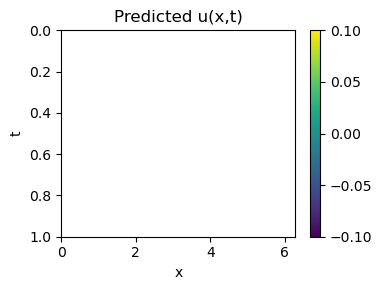

In [26]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('./convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

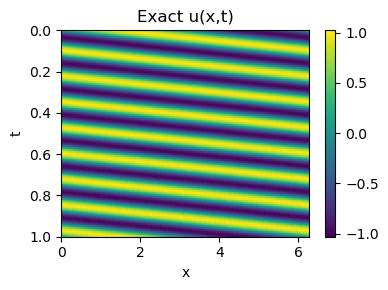

In [27]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_exact.png')
plt.show()

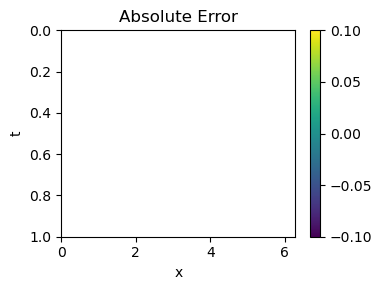

In [28]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_error.png')
plt.show()